In [64]:
import os
import numpy as np
import pandas as pd
from jiwer import wer
import tensorflow as tf
from IPython import display
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [65]:
# Create necessary directories if they don't exist
os.makedirs("Graphs", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("model", exist_ok=True)

data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

In [66]:
# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

In [67]:
split = int(len(metadata_df) * 0.80)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 10480
Size of the training set: 2620


In [68]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_int = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
int_to_char = keras.layers.StringLookup(vocabulary=char_to_int.get_vocabulary(), oov_token="", invert=True)
print(f"The vocabulary is: {char_to_int.get_vocabulary()} "f"(size ={char_to_int.vocabulary_size()})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


In [69]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384

def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [70]:
batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

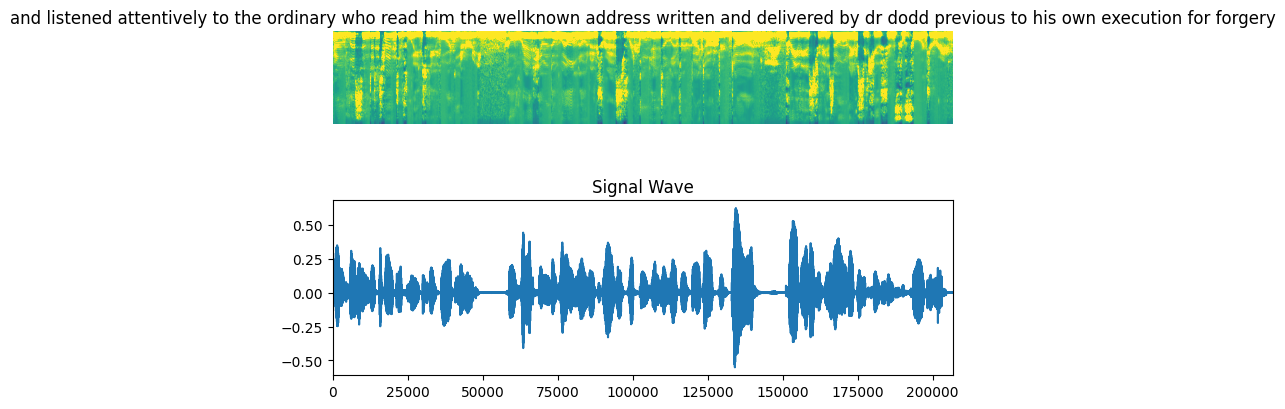

In [71]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [72]:
# Define CTCLoss function
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [73]:
# Build the CNN + BiLSTM + CTC model
def build_model(input_dim, output_dim, rnn_units=128):
    """Model with CNN + BiLSTM + CTC."""
    input_spectrogram = layers.Input((None, input_dim), name="input")
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    
    # Convolutional layer
    x = layers.Conv2D(
        filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="conv"
    )(x)
    x = layers.BatchNormalization()(x)
    
    # Reshape for BiLSTM
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    
    # BiLSTM layers
    x = layers.Bidirectional(layers.LSTM(rnn_units, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(rnn_units, return_sequences=True))(x)
    
    # Dense layer
    x = layers.Dense(units=rnn_units, activation="relu")(x)
    
    # Output layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    
    model = keras.Model(input_spectrogram, output, name="CNN_BiLSTM_CTC")
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss=CTCLoss)
    return model

In [74]:
# Get the model
model = build_model(input_dim=fft_length // 2 + 1, output_dim=char_to_num.vocabulary_size(), rnn_units=512)
model.summary(line_length=110)

Model: "CNN_BiLSTM_CTC"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv (Conv2D)                                   (None, None, 193, 32)                       320              
                                                                                                              
 batch_normalization_3 (BatchNormalization)      (None, None, 193, 32)                  

In [75]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(int_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

In [77]:
# Directories for saving checkpoints, the final model, and the graph
checkpoint_dir = 'checkpoint'
final_model_dir = 'models'
graph_dir = 'graphs'
model_dir = 'model'

# Ensure directories exist
os.makedirs(checkpoint_dir)
os.makedirs(final_model_dir)
os.makedirs(graph_dir)

class CallbackEval(keras.callbacks.Callback):
    def __init__(self, dataset, int_to_char):
        super().__init__()
        self.dataset = dataset
        self.int_to_char = int_to_char  # Ensure that int_to_char is passed to the callback

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = self.model.predict(X)  # Use self.model to access the model inside a callback
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = tf.strings.reduce_join(self.int_to_char(label)).numpy().decode("utf-8")
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate at epoch {epoch + 1}: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

# Callback for saving model checkpoints
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(checkpoint_dir, 'model_epoch_{epoch:03d}.weights.h5'),
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

# Create the validation callback
validation_callback = CallbackEval(validation_dataset, int_to_char)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=2,
    callbacks=[validation_callback, model_checkpoint_callback]
)

# Save the final model in .keras format
model.save(os.path.join(model_dir, 'model.keras'))
print("Model Saved.")

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the loss graph
plt.savefig(os.path.join(graph_dir, 'loss_graph.png'))
plt.close()
print("Loss graph saved.")

FileExistsError: [Errno 17] File exists: 'models'